In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

Срок выполнения задания: 17 марта 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монетизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.


#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


In [3]:
df = pd.read_csv('user_transactions.csv')
df['event_date'] = df.event_date.apply(date_converter)

In [88]:
df.tail(10)

,event_date,user_id,product,amount,transactions
1278176,2020-12-29,9093784927589212377,basic,110.0,1
1278177,2020-12-29,9141192109375648623,basic,130.0,1
1278178,2020-12-29,9145211684315137844,basic,100.0,1
1278179,2020-12-29,9156579950701208100,advanced,999.0,1
1278180,2020-12-29,9163888682358806390,basic,130.0,1
1278181,2020-12-29,9175681616034416929,advanced,679.0,1
1278182,2020-12-29,9190225485662720178,advanced,439.0,1
1278183,2020-12-29,9192452502210580022,basic,149.0,1
1278184,2020-12-29,9202424686732081420,basic,947.0,3
1278185,2020-12-29,9219633945080038962,basic,79.0,1


In [159]:
df.shape

(1278186, 5)

Для начала исследуем общий график распределения метрики Average Revenue Per User, а затем для пользователей базового тарифа и продвинутого тарифа по отдельности

Min amount = 8.00
Max amount = 1869.00
Scatter in the data = 1861.00


<AxesSubplot:title={'center':'Histogram of Average Revenue Per User'}, xlabel='Average Revenue Per User', ylabel='Amount of people'>

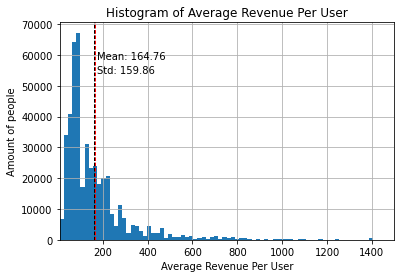

In [194]:
total = df.groupby('user_id')
arpu = total.amount.sum() / total.transactions.sum()

arpu_mean, arpu_std = arpu.mean(), arpu.std()
plt = arpu.hist(bins=100)
plt.set_xlim([8, 1500])

plt.axvline(arpu_mean, color='r', linestyle='dashed', linewidth=1)
plt.text(arpu_mean*1.05, 65000*0.9, 'Mean: {:.2f}'.format(arpu_mean))

plt.axvline(arpu_std, color='k', linestyle='dashed', linewidth=1)
plt.text(arpu_std*1.1, 60000*0.9, 'Std: {:.2f}'.format(arpu_std))

plt.set_xlabel('Average Revenue Per User')
plt.set_ylabel('Amount of people')
plt.set_title('Histogram of Average Revenue Per User')

arpu_max, arpu_min = arpu.max(), arpu.min()
print('Min amount = {:.2f}'.format(arpu_min))
print('Max amount = {:.2f}'.format(arpu_max))
print('Scatter in the data = {:.2f}'.format(arpu_max - arpu_min))
plt

График распределения ARPU для пользователей basic product

Min amount = 8.00
Max amount = 529.00
Scatter in the data = 521.00


<AxesSubplot:title={'center':'Histogram of Average Revenue for Basic Product'}, xlabel='Average Revenue Per User', ylabel='Amount of people'>

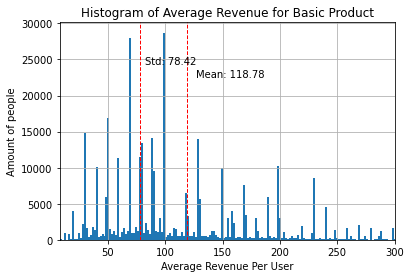

In [193]:
basic = df[df['product'] == 'basic'].groupby('user_id')
basic_mean = basic['amount'].sum() / basic.transactions.sum()
basic_arpu_mean = basic_mean.mean()
basic_arpu_std = basic_mean.std()

plt = basic_mean.hist(bins=300)
plt.set_xlim([8, 300])

plt.axvline(basic_arpu_mean, color='r', linestyle='dashed', linewidth=1)
plt.text(basic_arpu_mean*1.07, 25000*0.9, 'Mean: {:.2f}'.format(basic_arpu_mean))

plt.axvline(basic_arpu_std, color='r', linestyle='dashed', linewidth=1)
plt.text(basic_arpu_std*1.05, 27000*0.9, 'Std: {:.2f}'.format(basic_arpu_std))

plt.set_xlabel('Average Revenue Per User')
plt.set_ylabel('Amount of people')
plt.set_title('Histogram of Average Revenue for Basic Product')

basic_min, basic_max = basic_mean.min(), basic_mean.max()
print('Min amount = {:.2f}'.format(basic_min))
print('Max amount = {:.2f}'.format(basic_max))
print('Scatter in the data = {:.2f}'.format(basic_max - basic_min))
plt

График распределения ARPU для пользователей advanced product

Min amount = 20.00
Max amount = 1869.00
Scatter in the data = 1849.00


<AxesSubplot:title={'center':'Histogram of Average Revenue for Advanced Product'}, xlabel='Average Revenue Per User', ylabel='Amount of people'>

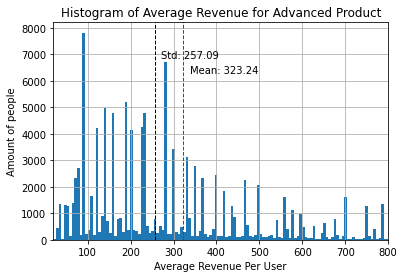

In [204]:
advanced = df[df['product'] == 'advanced'].groupby('user_id')
advanced_mean = advanced['amount'].sum() / advanced.transactions.sum()
advanced_arpu_mean, advanced_arpu_std = advanced_mean.mean(), advanced_mean.std()

plt = advanced_mean.hist(bins=300)
plt.set_xlim([20, 800])

plt.axvline(advanced_arpu_mean, color='r', linestyle='dashed', linewidth=1)
plt.text(advanced_arpu_mean*1.05, 7000*0.9, 'Mean: {:.2f}'.format(advanced_arpu_mean))

plt.axvline(advanced_arpu_std, color='k', linestyle='dashed', linewidth=1)
plt.text(advanced_arpu_std*1.05, 7600*0.9, 'Std: {:.2f}'.format(advanced_arpu_std))

plt.set_xlabel('Average Revenue Per User')
plt.set_ylabel('Amount of people')
plt.set_title('Histogram of Average Revenue for Advanced Product')


advanced_min, advanced_max = advanced_mean.min(), advanced_mean.max()
print('Min amount = {:.2f}'.format(advanced_min))
print('Max amount = {:.2f}'.format(advanced_max))
print('Scatter in the data = {:.2f}'.format(advanced_max - advanced_min))                                
plt

Теперь посмотрим на распределение кол-ва транзакций (общее/базового продукта/продвинутого продукта)

Min count = 1
Max count = 3070
Scatter in the data = 3069
Mean value = 3.70
Std value = 16.52


<AxesSubplot:>

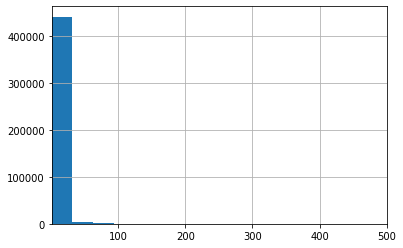

In [98]:
transactions_count = total['transactions'].sum()
plt = transactions_count.hist(bins=100)
plt.set_xlim([1, 500])
transactions_max, transactions_min = transactions_count.max(), transactions_count.min()
print('Min count =', transactions_min)
print('Max count =', transactions_max)
print('Scatter in the data =', transactions_max-transactions_min)
print('Mean value = {:.2f}'.format(transactions_count.mean()))
print('Std value = {:.2f}'.format(transactions_count.std()))
plt

Min count = 1
Max count = 2710
Scatter in the data= 2709
Mean value = 3.57
Std value = 15.21


<AxesSubplot:>

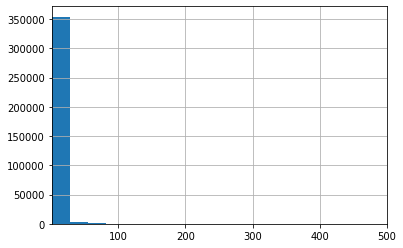

In [99]:
basic_transactions_count = basic['transactions'].sum()
plt = basic_transactions_count.hist(bins=100)
plt.set_xlim([1, 500])
basic_transactions_min, basic_transactions_max = basic_transactions_count.min(), basic_transactions_count.max()
print('Min count =', basic_transactions_min)
print('Max count =', basic_transactions_max)
print('Scatter in the data=', basic_transactions_max - basic_transactions_min)
print('Mean value = {:.2f}'.format(basic_transactions_count.mean()))
print('Std value = {:.2f}'.format(basic_transactions_count.std()))
plt

Min count = 1
Max count = 1248
Mean value = 3.09
Std value = 14.66


<AxesSubplot:>

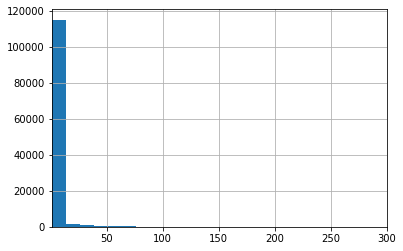

In [100]:
advanced_transactions_count = advanced['transactions'].sum()
plt = advanced_transactions_count.hist(bins=100)
plt.set_xlim([1, 300])
print('Min count =', advanced_transactions_count.min())
print('Max count =', advanced_transactions_count.max())
print('Mean value = {:.2f}'.format(advanced_transactions_count.mean()))
print('Std value = {:.2f}'.format(advanced_transactions_count.std()))
plt

In [113]:
paying_users_cnt = df[df['transactions'] > 0]['user_id'].count()
basic_paying_users_cnt = df[(df['transactions'] > 0) & (df['product'] == 'basic')]['user_id'].count()
advanced_paying_users_cnt = df[(df['transactions'] > 0) & (df['product'] == 'advanced')]['user_id'].count()
print('Amount of paying users =', paying_users_cnt)
print('Amount of paying users with basic product =', basic_paying_users_cnt)
print('Amount of paying users with advanced product =', advanced_paying_users_cnt)    

Amount of paying users = 1278186
Amount of paying users with basic product = 990428
Amount of paying users with advanced product = 287758


Нарисуем также boxplot для average revenue per user

/Users/ivtarasyuk/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ivtarasyuk/Library/Python/3.8/lib/python/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:>

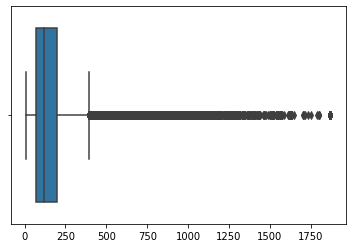

In [205]:
aov = total['amount'].sum() / total['transactions'].sum()
plt = sns.boxplot(aov, orient = 'v')
plt

Проанализируем также average order value (per user) = total sum(amount) / total sum(transactions) 

In [207]:
aov = df.amount.sum() / df.transactions.sum()
print('Average Order Value = {:.2f}'.format(aov))

Average Order Value = 185.24


У нас есть 2 гипотезы:

1) Дополнительное информирование об эффективности услуг будет стимулировать их покупку;

2) Повышение цены базового продукта должно стимулировать покупку продвинутого продукта

Для 1 гипотезы зафиксируем следующие метрики:

average revenue per user (ARPU)

количество транзакций per user

average order value per user (AOV)

количество paying users

Будем отслеживать рост данных метрик. В случае, если выручка с одного пользователя и количество пользователей увеличились или увеличилось число транзакций и средний чек, то общая выручка также увеличалась. Проверяем, статистически ли значимо данное изменение в общей выручке или нет

Для 2 гипотезы в качестве метрик возьмём следующие две:

количество транзакций

средний чек транзакции 

Сравним метрики для базового и продвинутого продуктов до повышения цены и после. В случае, если изменение в данных будет статистически значимым, нулевая гипотеза подтвердится

Теперь рассмотрим разные планы проведения экспериментов (разные по длительности и размеру группы)

In [146]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date >= start_date) & (data.event_date <= start_date + datetime.timedelta(days=delta))]
    tmp = tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id) % 100 <= int(100 * share)]
    return x

In [151]:
from statsmodels.stats.power import tt_ind_solve_power

for duration in range(21, 98, 7):
    for size in range (2, 6, 2):
        
        x1 = choose_date(df, min(df.event_date), duration, size) #получаем необходимую подвыборку
 
        mean = x1.amount.mean()
        std = x1.amount.std()
 
        alpha = 0.01
        power = 0.8
        result_effect = 0.04 # целевой размер относительного отклонения исходной метрики
        effect_size = (mean /std) * result_effect
 
    
        sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
        print('duration:', duration, 
              'group size:', size/10,
              '{:.2f}'.format(sample_vol / x1.shape[0]))

duration: 21 group size: 1 1.34
duration: 21 group size: 3 1.34
duration: 21 group size: 5 1.34
duration: 21 group size: 7 1.34
duration: 21 group size: 9 1.34
duration: 28 group size: 1 1.30
duration: 28 group size: 3 1.30
duration: 28 group size: 5 1.30
duration: 28 group size: 7 1.30
duration: 28 group size: 9 1.30
duration: 35 group size: 1 1.28
duration: 35 group size: 3 1.28
duration: 35 group size: 5 1.28
duration: 35 group size: 7 1.28
duration: 35 group size: 9 1.28
duration: 42 group size: 1 1.27
duration: 42 group size: 3 1.27
duration: 42 group size: 5 1.27
duration: 42 group size: 7 1.27
duration: 42 group size: 9 1.27
duration: 49 group size: 1 1.26
duration: 49 group size: 3 1.26
duration: 49 group size: 5 1.26
duration: 49 group size: 7 1.26
duration: 49 group size: 9 1.26
duration: 56 group size: 1 1.26
duration: 56 group size: 3 1.26
duration: 56 group size: 5 1.26
duration: 56 group size: 7 1.26
duration: 56 group size: 9 1.26
duration: 63 group size: 1 1.23
duration

Видно, что с увеличением длительности увеличивается точность (множитель того, во сколько необходимо изменить размер выборки, уменьшается)

Поэтому наилучшие результаты при длительности 91 день